In [2]:
import keras
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

print(keras.__version__)
print(tf.__version__)

/home/paradox/anaconda3/envs/machine-learning/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


2.1.4
1.5.0


In [3]:
import keras.layers as L
from keras.datasets import mnist

## PCA Autoencoder

We all know what PCA (Principal Component Analysis) is. All PCA does is nothing but find an optmial hyperplane where higher dimensional data can be projected onto, in order to reduce the dimension of the original data. Normally, that hyperplane is along the eigen vector. It requires some old-school mathematics to do so.

However, same can be done using neural networks to reduce the dimension as well as encode a higher dimensional data into lower dimensional features. Such technique is called **Encoding**.  

The reverse of encoding is **decoding**.


### Example
Say we have an image **64 X 64**.  

Number of pixels = 4096  
Number of channels = 1 (for simplicity)

When we try to create a model for image with such (relatively) huge number of pixels, the machine learning model will be computationally expensive. So, we encode the pixels for further usage. Further usages can be:
- image labelling
- image captioning
- semantic segmentation
- ...

### Architecture
The architecture that **encodes** and **decodes** is **autoencoder** - as simple as that. :D

**Encoder**
- flatten the original image -> 2d to 1d
- Add neural network layers (dense)
- This dense layer's size is our encoding code size

**Decoder**
- accept a 1d vector -> encoded vector
- add a dense layer equal to the size of original image (including the number of channels)
- Hence, we get original image

Although we can technically compress an image (or remove irrelevant features - in case of image, pixels), 
the reconstruction is lossy. While encoding the image, we lose certain information that the decoder will never recover.
So, our best effort lies in minimizing such reconstruction error.

So, an autoencoder is nothing but a neural network as:

input -> encoder -> [encoded output] -> decoder -> [decoded output as near to the input]


In [23]:
def build_pca_autoencoder(img_shape, code_size):
    """
        img_shape: (height, width, num_channel)
        code_size: size of encoding -> dimensionality of latent space
    """
    encoder = keras.models.Sequential()
    
    # accept image
    encoder.add(L.InputLayer(img_shape))
    
    # flatten pixels
    encoder.add(L.Flatten())
    
    # add a dense layer to encode the pixels
    encoder.add(L.Dense(code_size))

    decoder = keras.models.Sequential()
    # accept encoded input
    decoder.add(L.InputLayer((code_size,)))
    
    # add a dense layer equal to original image (with channels)
    decoder.add(L.Dense(np.prod(img_shape)))
    
    # reshape as 2d image (h, w, c)
    decoder.add(L.Reshape(img_shape))
    
    return encoder, decoder

In [16]:
def load_mnist():
    (X_train, label_train), (X_test, label_test) = mnist.load_data()
    X_train = np.expand_dims(X_train, axis=0)
    X_test = np.expand_dims(X_test, axis=0)
    return [(X_train, label_train), (X_test, label_test)]

In [17]:
#data_train, data_test = load_mnist()

In [22]:
# load the shit
(X_train, label_train), (X_test, label_test) = mnist.load_data()
X_train = X_train.reshape(60000, 28, 28, 1)/255
X_test = X_test.reshape(10000, 28, 28, 1)/255
img_shape = X_train.shape[1:]
print(img_shape)

(28, 28, 1)


3


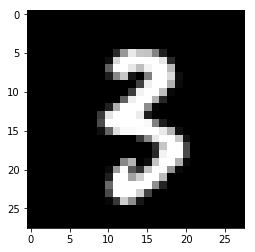

In [9]:
i = 45000
print(label_train[i])
plt.imshow(X_train[i].reshape(img_shape[:-1]), 'gray')

In [10]:
encoder, decoder = build_pca_autoencoder(img_shape, code_size=24)

inp = L.Input(img_shape)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inp,reconstruction)
autoencoder.compile(optimizer='adam', loss='mse')

In [11]:
autoencoder.fit(x=X_train, y=X_train, epochs=3,
                validation_data=[X_test, X_test])

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 59s 980us/step - loss: 0.0267 - val_loss: 0.0212
Epoch 2/3
60000/60000 [==============================] - 77s 1ms/step - loss: 0.0216 - val_loss: 0.0211
Epoch 3/3
60000/60000 [==============================] - 76s 1ms/step - loss: 0.0216 - val_loss: 0.0210


In [25]:
def visualize(img, encoder, decoder):
    """Draws original, encoded and decoded images"""
    code = encoder.predict(img[None])[0]
    decoded = decoder.predict(code[None])[0]

    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(img.reshape(28, 28), 'gray')

    plt.subplot(1, 3, 2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]), 'gray')

    plt.subplot(1, 3, 3)
    plt.title("Reconstructed")
    plt.imshow(decoded.clip(0, 1).reshape(img_shape[:-1]), 'gray')
    plt.show()

Final MSE: 0.021037264090776442


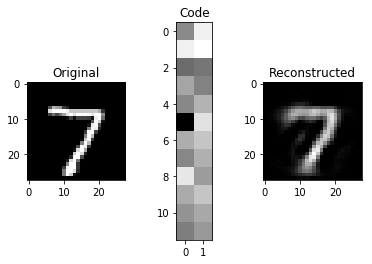

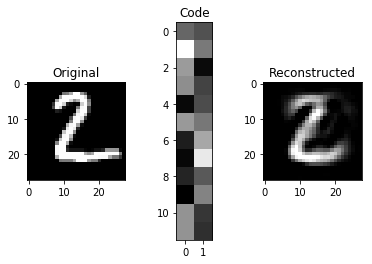

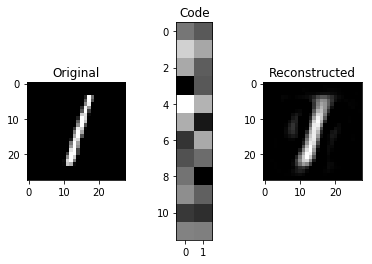

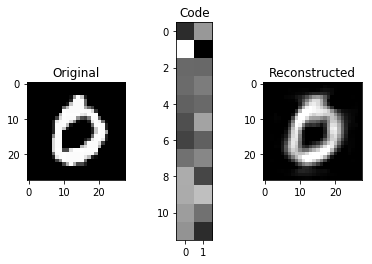

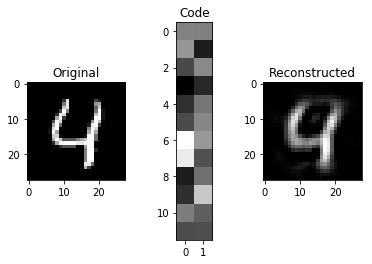

In [28]:
score = autoencoder.evaluate(X_test, X_test, verbose=0)
print("Final MSE:", score)

for i in range(5):
    img = X_test[i]
    visualize(img, encoder, decoder)

7 2


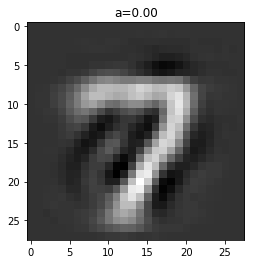

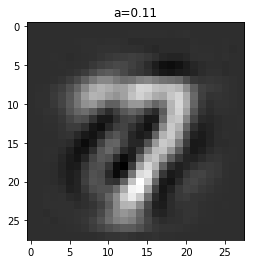

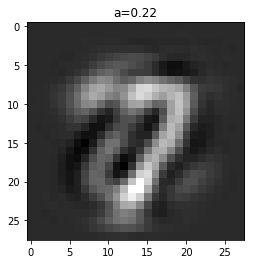

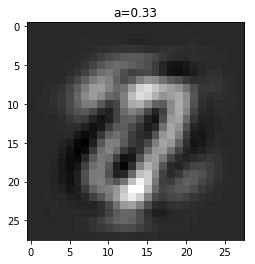

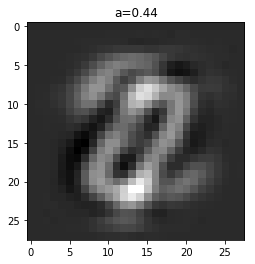

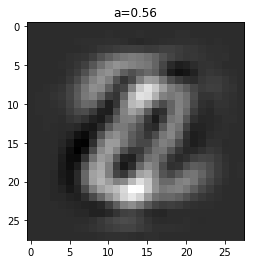

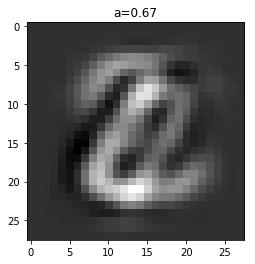

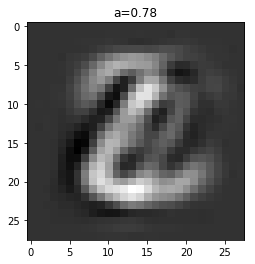

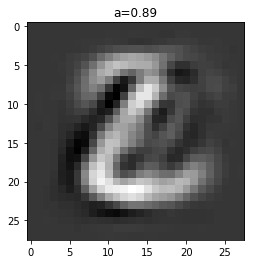

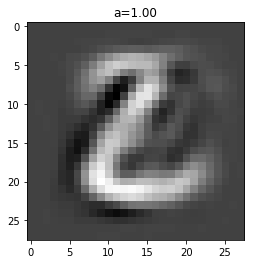

In [34]:
# naive image morphing using the encodings
indexes = [0, 1]
image1, image2 = X_test[indexes]
label1, label2 = label_test[indexes]
print(label1, label2)

code1, code2 = encoder.predict(np.stack([image1, image2]))
#plt.figure(figsize=[10,4])

for i,a in enumerate(np.linspace(0, 1, num=10)):
    output_code = code1*(1-a) + code2*(a)
    output_image = decoder.predict(output_code[None])[0]

    plt.imshow(output_image.reshape(img_shape[:-1]), 'gray')
    plt.title("a=%.2f"%a)
    plt.show()

